In [2]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from planar_code import PlanarLattice
from graph_operations import min_weight_syndrome_matching
from visualization import plot_matchings


BOUNDARIES = np.array((1,0), dtype=int)


def single_shot_correction(lattice):
    lattice.reset()
    lattice.apply_errors()
    syndrome = lattice.measure_syndrome()
    matching, paths = min_weight_syndrome_matching(lattice, syndrome, pathfinding='manhattan')
    for path in paths:
        lattice.apply_edge_operators(path)
    try:
        return lattice.detect_logical_errors()
    except Exception as e:
        plot_matchings(lattice, syndrome, pathfinding='manhattan')
        raise e


def logical_error_rate(p, L, samples=int(1e3), verbose=True):
    lattice = PlanarLattice(L, L, BOUNDARIES, p)
    logical_errors = 0
    sample_range = tqdm(
        range(samples),
        desc=f'Calculating logical errors for p={round(p,3)} on length {L} square lattice'
    ) if verbose else range(samples)
    for _ in sample_range:
        logical_errors += single_shot_correction(lattice)
            
    return logical_errors / samples


def linear_sweep(L, domain=(0,1), points=100):
    p_array = np.linspace(*domain, points+2)
    logical_errors = []
    for p in tqdm(
        p_array,
        desc=f'L={L}: Sweeping {points} values over domain {[round(d, 3) for d in domain]}'
    ):
        logical_errors.append(logical_error_rate(p, L, verbose=False))
    return p_array, np.array(logical_errors)


def adaptive_sweep(L, domain=(0,1), points_this_level=5, total_points=25):
    if total_points < points_this_level:
        return [], []
    
    p_array, logical_errors = linear_sweep(L, domain, points=points_this_level)
    
    prev = 0
    deltas = []
    for i, error in enumerate(logical_errors):
        delta = abs(error - prev)
        deltas.append((i, delta))
        prev = error
    sort_by_delta = sorted(deltas, key=lambda a: a[-1])
    x0, x1 = sorted((sort_by_delta[0][0], sort_by_delta[len(deltas) // 2 + 1][0]))
    
    inner_p, inner_errors = adaptive_sweep(
        L, domain=(p_array[x0], p_array[x1]), total_points=total_points-points_this_level)
    p_array = list(p_array)
    p_array.extend(inner_p)
    logical_errors.extend(inner_errors)
    sorted_output = sorted(list(zip(p_array, logical_errors)))
    ps = []
    ls = []
    for p, l in sorted_output:
        ps.append(p)
        ls.append(l)
    return ps, ls

In [4]:
SAVE_DIR = 'temp'
SAVED_FILES = []

In [31]:
for L in [8]:
    fname = os.path.join(SAVE_DIR, f'{L}.pkl')
    with open(fname, 'wb') as fi:
        pickle.dump(linear_sweep(L, domain=(0,0.3), points=100), fi)
    SAVED_FILES.append(fname)

L=8: Sweeping 100 values over domain [0, 0.3]:   0%|          | 0/102 [00:00<?, ?it/s]

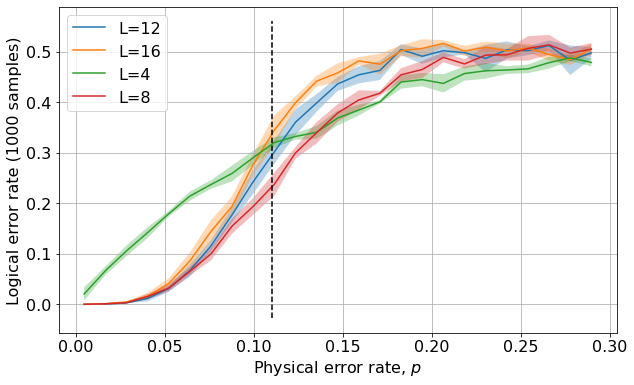

In [32]:
plt.rcParams.update({'font.size': 16})
BATCH = 4

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.grid(True)
ax.set_xlabel('Physical error rate, $p$')
ax.set_ylabel('Logical error rate (1000 samples)')

for fname in os.listdir(SAVE_DIR):
    if not fname.endswith('.pkl'):
        continue
    fpath = os.path.join(SAVE_DIR, fname)
    with open(fpath, 'rb') as fi:
        L = int(fname.split('.')[0])
        errors = pickle.load(fi)
        mean_errors = []
        error_stdev = []
        for error_array in errors:
            mean_array = []
            stdev_array = []
            for i in range(len(error_array)//4):
                error_batch = error_array[i*BATCH:(i+1)*BATCH]
                mean_array.append(sum(error_batch)/BATCH)
                stdev_array.append(np.std(error_batch))
            mean_errors.append(np.array(mean_array))
            error_stdev.append(np.array(stdev_array))
        xvals, yvals = mean_errors
        ax.fill_between(xvals, yvals+error_stdev[-1], yvals-error_stdev[-1], alpha=0.3, zorder=1)
        ax.plot(xvals, yvals, label=f'L={L}', zorder=2)

ax.vlines(0.11, *ax.get_ylim(), color='black', linestyle='dashed', zorder=3)
ax.legend()